# IceCube SSA and mCT SSA Comparison
#### (and other data, such as density)
###### notebook by Kaitlin Meyer
###### Completed 4/28/2023

#### Load Packages

In [1]:
#import packages
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
from pathlib import Path
import codecs
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import statistics as stats
from scipy.stats import norm
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [2]:
#move to directory with field data in it
os.chdir('field_data')
os.getcwd()

'C:\\Users\\meyer.1597.RF\\OneDrive - The Ohio State University\\Documents\\data\\field_data'

#### Define Functions

In [3]:
#convert everything to UTF-8 encoding
def convert_UTF8(file): 
    og_fname = os.path.split(file)  #original file name
    fname = og_fname[1][:-4] + '_UTF8.csv' 
    BLOCKSIZE = 300000 #desired size in bytes
    try:
        with codecs.open(file, "r") as sourceFile:
            with codecs.open(fname, "w", "utf-8") as targetFile:
                while True:
                    contents = sourceFile.read(BLOCKSIZE)
                    if not contents:
                        break
                    targetFile.write(contents)
    except:
        print('Failed on file: ' + str(fname))

In [4]:
def getIndexes(dfObj, value):
     
    # Empty list
    listOfPos = []
     
    # isin() method will return a dataframe with
    # boolean values, True at the positions   
    # where element exists
    result = dfObj.isin([value])
     
    # any() method will return
    # a boolean series
    seriesObj = result.any()
 
    # Get list of column names where
    # element exists
    columnNames = list(seriesObj[seriesObj == True].index)
    
    # Iterate over the list of columns and
    # extract the row index where element exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
 
        for row in rows:
            listOfPos.append(row)
    return listOfPos

#### Test Pit Comparison (Bacon Rind #1)

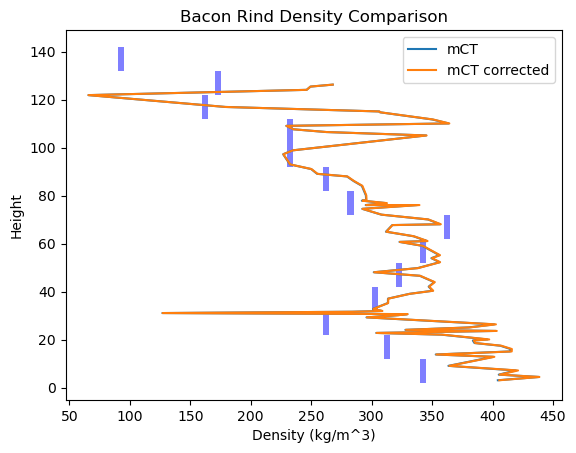

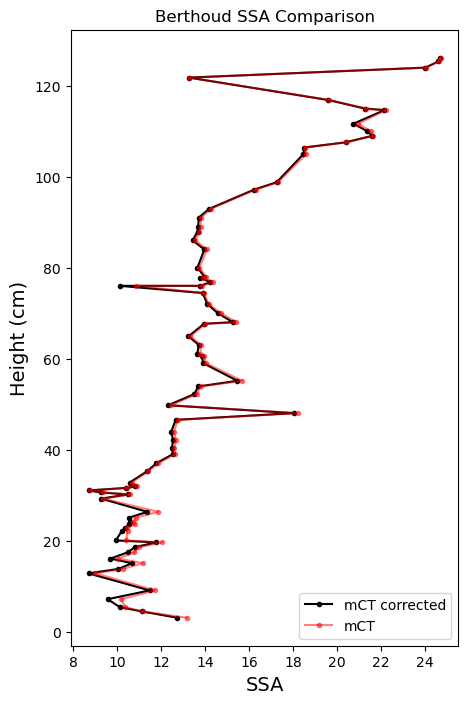

In [5]:
#example pit - baconrind1

#SSA
SSA_br_df = pd.read_csv('SSA_berthoud1.csv', header=14)
SSA_br_df.head()

#density
dens_br_df = pd.read_csv('density_berthoud1.csv', header=7)
dens_br_df.head()

#mCT
mCT_br_df = pd.read_csv('../mCT_data/MCT_3D_csv/berthoud1_mCT_3D.csv', header=0)
#mCT_br_df = pd.read_csv('baconrind1_mCT_3D.csv', header=0)
mCT_br_df.head()

#calculate corrected density
den_corr = ((mCT_br_df['Object volume'] + mCT_br_df['Volume of closed pores'])/(mCT_br_df['Total VOI volume']))*1000

#plot density
fig, ax = plt.subplots()
xmin = 300
xmax = 550
ax.plot(mCT_br_df['Percent object volume']*10, mCT_br_df['Height'], '-',label='mCT')
ax.plot(den_corr, mCT_br_df['Height'], '-',label='mCT corrected')
        
for i in range(len(dens_br_df)):
    ax.add_patch(Rectangle((dens_br_df['Avg_density(kg/m^3)'][i],dens_br_df['Bottom(cm)'][i]),5,10,facecolor=(0,0,1,0.5)))

plt.title('Bacon Rind Density Comparison')
plt.xlabel('Density (kg/m^3)')
plt.ylabel('Height')
plt.legend()
plt.show()

#calculate corrected SSA
ssa_og = mCT_br_df['Object surface / volume ratio']*(1/0.917)
ssa_corr = (mCT_br_df['Object surface']-mCT_br_df['Surface of closed pores'])/((mCT_br_df['Object volume']+mCT_br_df['Volume of closed pores'])*(.917))

#plot SSA
fig, ax = plt.subplots(figsize=(5,8))
ax.plot(ssa_corr, mCT_br_df['Height'],'.-',color='k',label='mCT corrected')
ax.plot(ssa_og, mCT_br_df['Height'],'.-',label='mCT',color='r',alpha=0.5)

plt.title('Berthoud SSA Comparison')
plt.xlabel('SSA', fontsize=14)
plt.ylabel('Height (cm)', fontsize=14)
#plt.xlim(0,50)
plt.legend(loc='lower right')
plt.show()


In [6]:
#read in csv data to df's within dictionaries

path = r'C:\Users\meyer.1597.RF\OneDrive - The Ohio State University\Documents\data\field_data'
files = os.listdir(path)
os.chdir(path)

#create a separate dictionary for each category of variables
ssa = {}
den = {}
strt = {}
temp = {}
wthr = {}
mCT = {}

for file in files:
    if file.startswith('SSA'): 
        og_fname = os.path.split(file) 
        fname = og_fname[1][:-4] + '_df'
        ssa[fname] = pd.read_csv(file, header=14)
    elif file.startswith('density'):
        og_fname = os.path.split(file) 
        fname = og_fname[1][:-4] + '_df'
        den[fname] = pd.read_csv(file, header = 7)
    elif file.startswith('stratigraphy'):
        og_fname = os.path.split(file) 
        fname = og_fname[1][:-4] + '_df'
        strt[fname] = pd.read_csv(file, header = 7)
    elif file.startswith('temperature'):
        og_fname = os.path.split(file) 
        fname = og_fname[1][:-4] + '_df'
        temp[fname] = pd.read_csv(file, header = 7)
    elif file.startswith('weather'):
        og_fname = os.path.split(file) 
        fname = og_fname[1][:-4] + '_df'
        wthr[fname] = pd.read_csv(file, header = 7)
    elif file.endswith('3D.csv'):
        og_fname = os.path.split(file) 
        fname = og_fname[1][:-4] + '_df'
        mCT[fname] = pd.read_csv(file, header = 0)
        
#save matching ssa and density to their own dictionaries
##so as not to pull matching df's every time we want to do something...
ssa_true = {}
den_true = {}
for name,df in mCT.items():
    for name2,df2 in den.items():
        var1 = name.split('_')
        var2 = name2.split('_')
        if var2[1].startswith(var1[0]):
            den_true[name2] = df2 
            
for name,df in mCT.items():
    for name2,df2 in ssa.items():
        var1 = name.split('_')
        var2 = name2.split('_')
        if var2[1].startswith(var1[0]):
            ssa_true[var2[1]] = df2

#### mCT Measurements: 2D and 3D

After the mCT scans go through reconstruction and thresholding, both 2D and 3D parameters can be derived. 2D parameters are given for each slice of a 2cm scan; there are generally between 600 and 1000 horizontal slices. 

#### Notes on SSA

SSA is defined as surface area per unit mass, and is given by:

$$
SSA=\frac{SAm^2}{Mkg}=\frac{SAm^2}{Vm^3\rho_{ice}}, 
$$

where SA is surface area in $m^2$, V is volume in $m^3$, and $\rho$ is the density of ice in $kgm^{-3}$. The density of ice is: 

$$
\rho_{ice}=917kgm^{-3}       
$$

In order to derive specific surface area from mCT 3D results, the following equation is used: 

$$
SSA={\frac{SA_s-SA_{cp}mm^2}{V_s+V_{cp}mm^3}}\cdot{\frac{1}{0.001m}}\cdot{\frac{1m^3}{917kg}},      
$$

where $SA_s$ is the surface area of the snow in $mm^2$, $SA_{cp}$ is the surface area of ice surrounding all closed pores in $mm^2$, $V_s$ is the volume of the snow sample in $mm^3$, and $V_{cp}$ is the volumne of all closed pore space in $mm^3$. Since IceCube SSA values are in units of $m^2kg^{-1}$, equation (1) is used to normalize the mCT SSA values by mass rather than volume. Since the mCT results are all in $mm$, the appropriate unit conversions are also included in equation (3). 

## Cleaning data
###### The following sections clean and format the data, and then looks at initial patterns. 

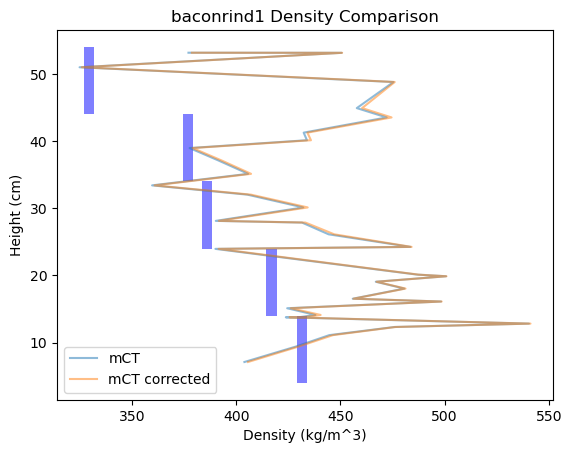

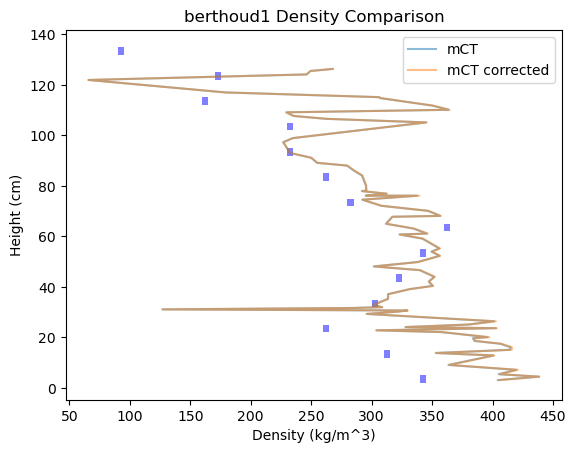

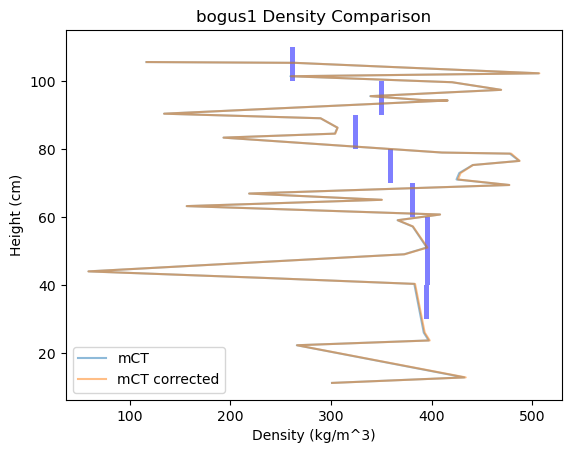

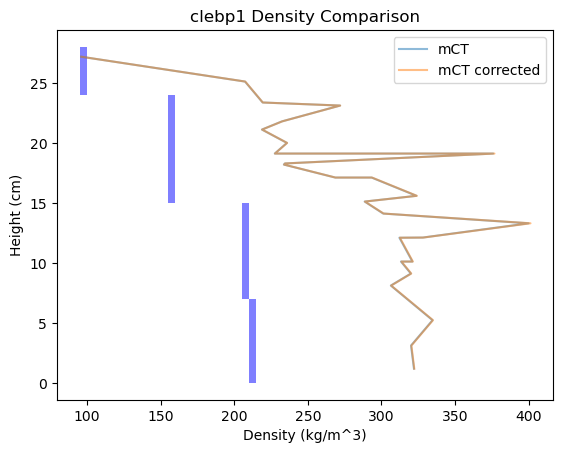

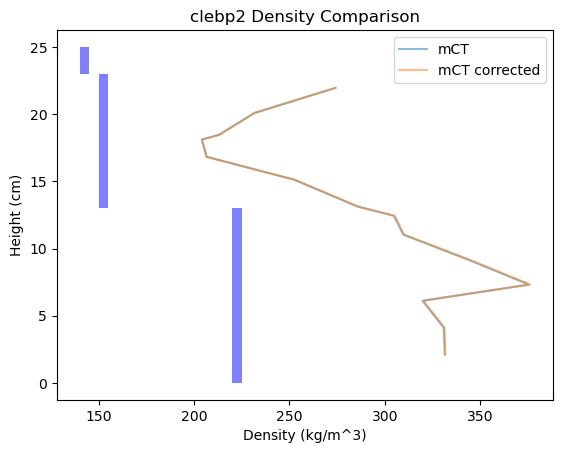

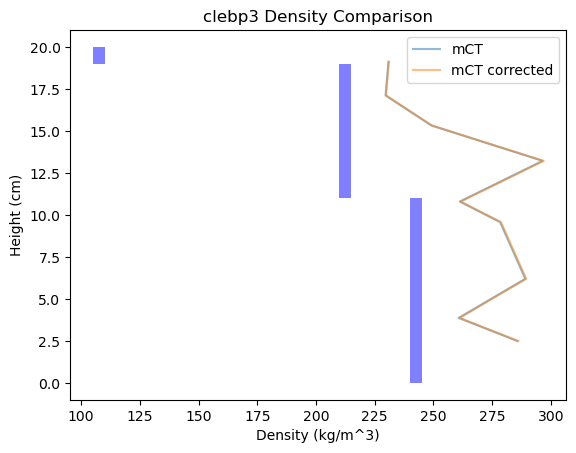

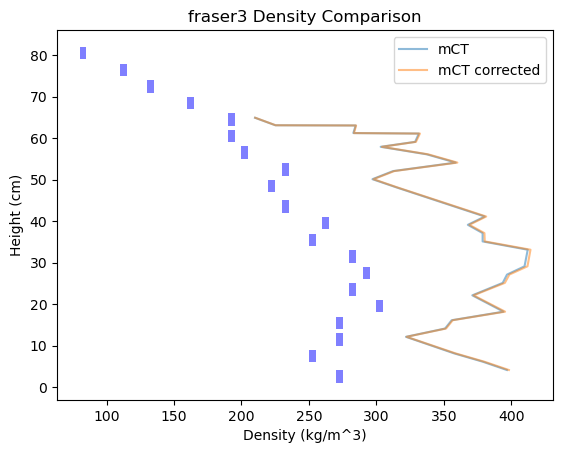

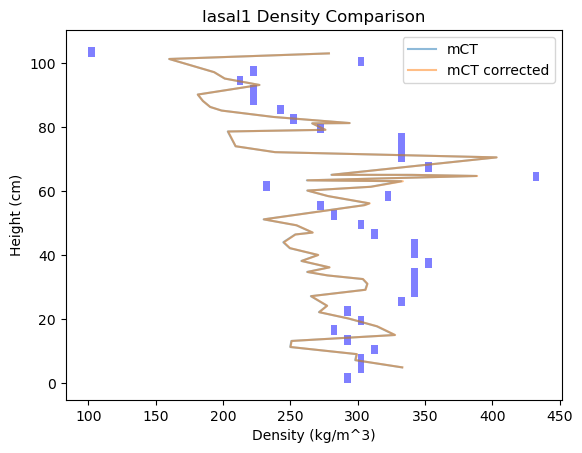

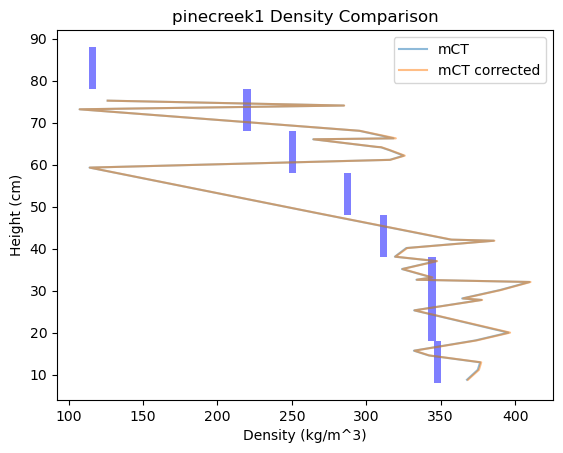

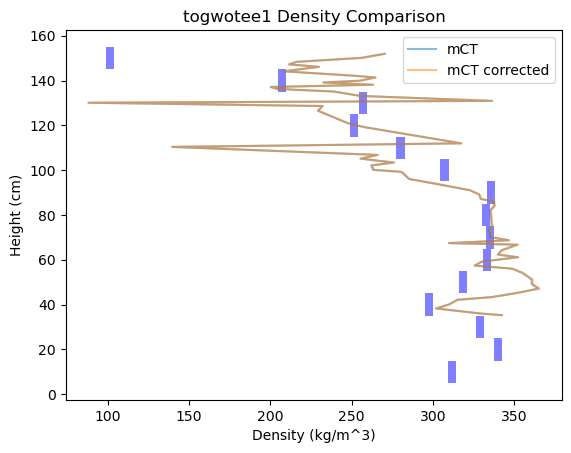

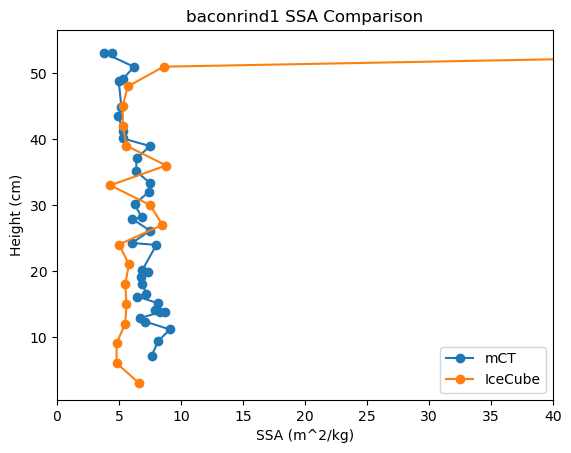

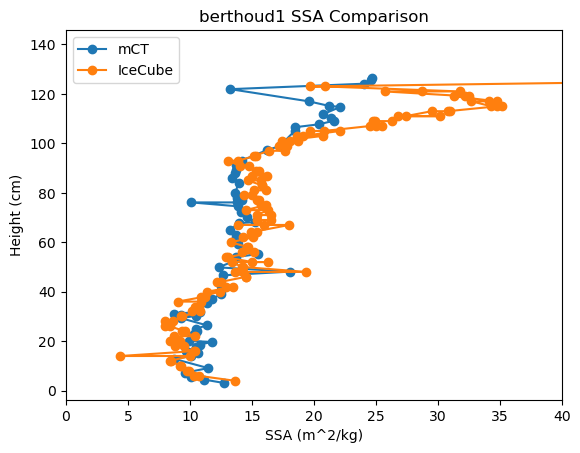

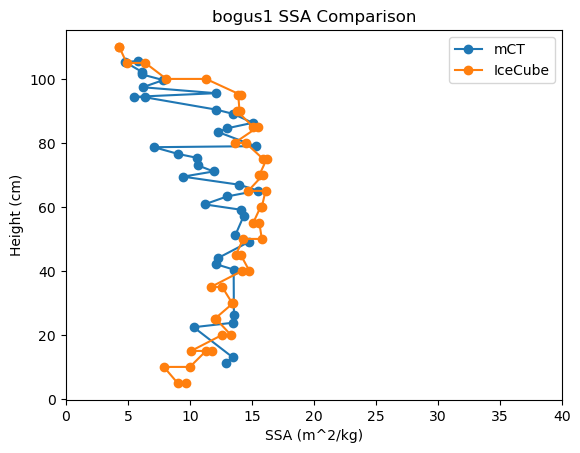

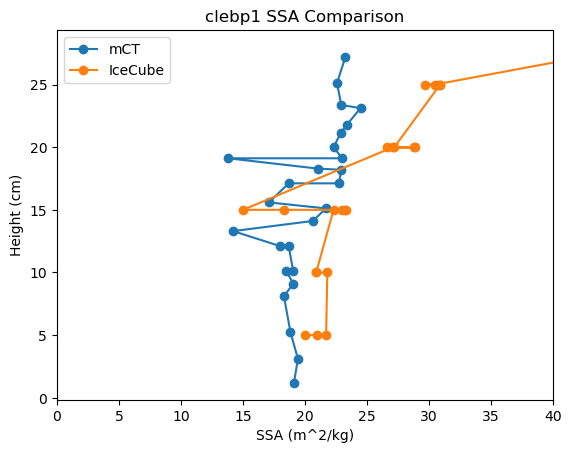

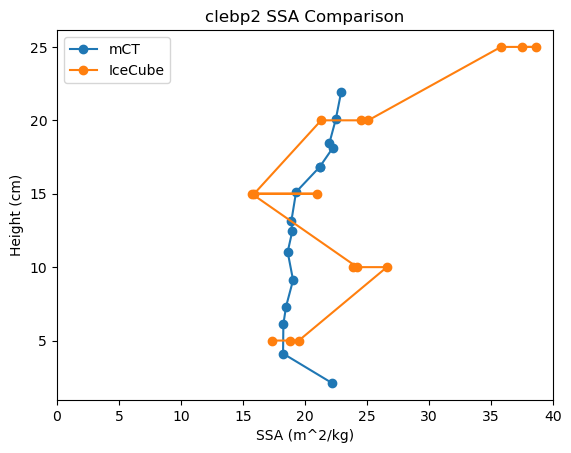

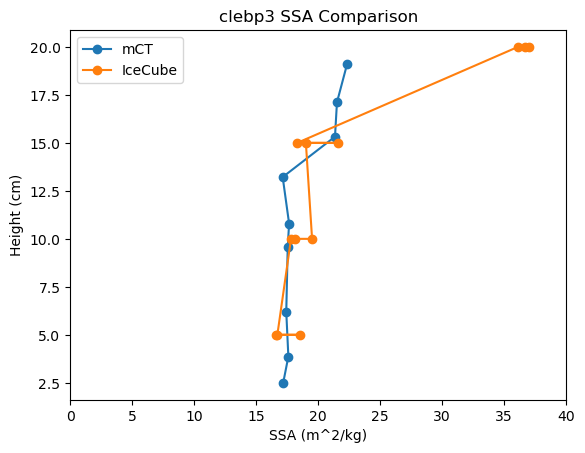

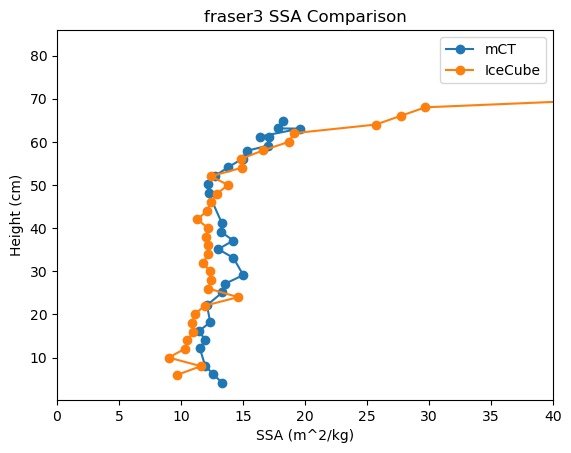

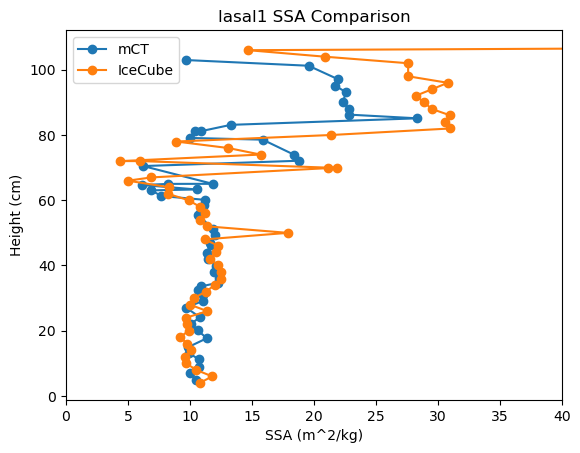

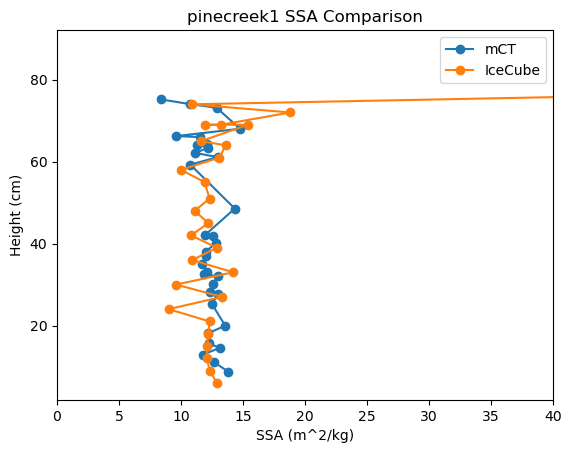

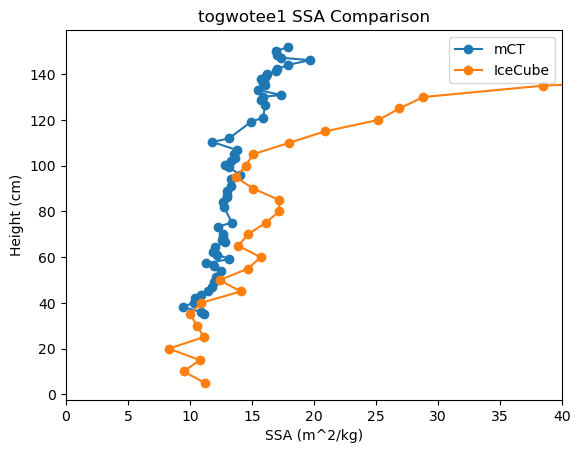

In [7]:
#plot density
for name,df in mCT.items():
    for name2,df2 in den.items():
        var1 = name.split('_')
        var2 = name2.split('_')
        if var2[1].startswith(var1[0]):
            fig, ax = plt.subplots()
            xmin = 100
            xmax = 600
            den_corr = ((df['Object volume'] + df['Volume of closed pores'])/(df['Total VOI volume']))*1000
            ax.plot(df['Percent object volume']*10, df['Height'], '-',label='mCT', alpha=0.5)
            ax.plot(den_corr, df['Height'], '-',label='mCT corrected',alpha=0.5)
            for i in range(len(df2)):
                h = df2['#Top(cm)'][i]-df2['Bottom(cm)'][i]
                ax.add_patch(Rectangle((df2['Avg_density(kg/m^3)'][i],df2['Bottom(cm)'][i]),5,h,facecolor=(0,0,1,0.5)))

            plt.title(str(var2[1])+' Density Comparison')
            plt.xlabel('Density (kg/m^3)')
            plt.ylabel('Height (cm)')
            plt.legend()
            plt.show()

#plot SSA
for name,df in mCT.items():
    for name2,df2 in ssa.items():
        var1 = name.split('_')
        var2 = name2.split('_')
        if var2[1].startswith(var1[0]):
            ssa_corr = (df['Object surface']-df['Surface of closed pores'])/((df['Object volume']+df['Volume of closed pores'])*(.917))
            fig, ax = plt.subplots()
            ax.plot(ssa_corr, df['Height'],'o-',label='mCT')
            ax.plot(df2['Specific_surface_area(m^2/kg)'], df2['Sample_top_height(cm)'],'o-',label='IceCube')

            plt.title(str(var2[1])+' SSA Comparison')
            plt.xlabel('SSA (m^2/kg)')
            plt.ylabel('Height (cm)')
            plt.xlim(0,40)
            plt.legend()
            plt.show()


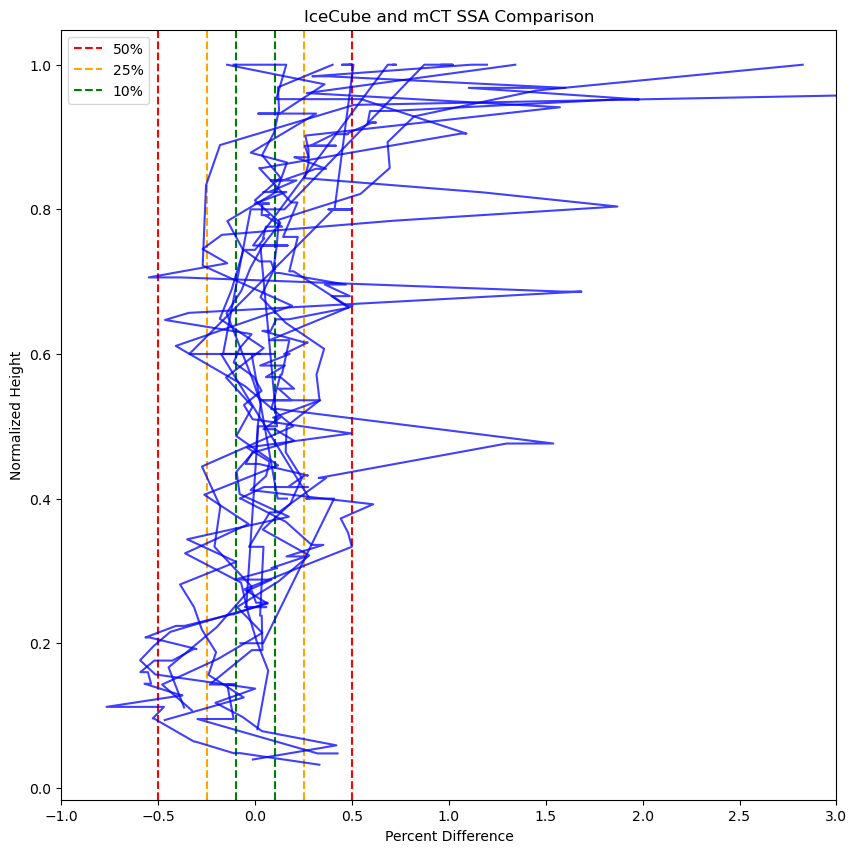

In [8]:
#calculate the percentage difference between mCT values and IceCube values SSA

#2. Interpolate the mCT results; save to new df
mCT_temp = mCT.copy()
mCT_interpolated = {}
for name,df in mCT_temp.items():
    temp = df[['Percent object volume','Object surface / volume ratio','Object surface','Surface of closed pores','Object volume','Volume of closed pores','Height']]
    ssa_corr = (temp['Object surface']-temp['Surface of closed pores'])/((temp['Object volume']+temp['Volume of closed pores'])*(.917))
    temp['ssa_corr']=ssa_corr
    new_heights = np.arange(np.min(temp['Height']),np.max(temp['Height']),0.50001)
    for h in new_heights:
        if h in temp['Height']:
            continue
        else:
            temp.loc[len(temp.index)] = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.round(h,2),np.nan]
    temp = temp.sort_values(by=['Height'])
    temp = temp.reset_index(drop=True)
    temp['ssa_corr'] = temp.set_index('Height')['ssa_corr'].interpolate('index').values
    temp['Percent object volume'] = temp.set_index('Height')['Percent object volume'].interpolate('index').values
    
    mCT_interpolated[name] = temp

percent_diff = {}
#compute percentage difference between IceCube SSA to average of 2.5cm of mCT measurements (should be an average of 6 values with my interpolation)
for name,df in ssa.items():
    for name2,df2 in mCT_interpolated.items():
        var2 = name.split('_')
        var1 = name2.split('_')
        if var2[1].startswith(var1[0]):
            percent = []
            height = []
            grain = []
            error = []
            ssa_mct = []
            ssa_ic = []
            names = []
            methods = []
            air_temps = []
            snow_temps = []
            moisture = []
            for i in range(0,len(df)):
                #if df['Sample_top_height(cm)'][i] in df2['Height'].values:
                x = float(df['Sample_top_height(cm)'][i])
                idx1 = getIndexes(round(df2*2)/2,x)
                #idx1 = getIndexes(df2,x)
                if len(idx1)>0:
                    idx = idx1 
                    if idx[0]>5:
                        ssa_av = (df2['ssa_corr'][idx[0]]+df2['ssa_corr'][idx[0]-1]+df2['ssa_corr'][idx[0]-2]+df2['ssa_corr'][idx[0]-3]+df2['ssa_corr'][idx[0]-4]+df2['ssa_corr'][idx[0]-5])/6
                        temp = (df['Specific_surface_area(m^2/kg)'][i]-ssa_av)/(ssa_av)
                        temp2 = df['Sample_top_height(cm)'][i]
                        temp3 = df['grain_type'][i]
                        temp4 = (abs(df['Specific_surface_area(m^2/kg)'][i]-ssa_av))
                        temp5 = ssa_av
                        temp6 = name.split('_')[1]
                        temp7 = df['Method'][i]
                        temp8 = df['Air Temp'][i]
                        temp9 = df['Snow Temp'][i]
                        temp10 = df['Moisture'][i]
                        temp11 = df['Specific_surface_area(m^2/kg)'][i]
                        #add temperature, temp gradient, sampling method, etc. 
                        percent.append(temp)
                        height.append(temp2)
                        grain.append(temp3)
                        error.append(temp4)
                        ssa_mct.append(temp5)
                        ssa_ic.append(temp11)
                        names.append(temp6)
                        methods.append(temp7)
                        air_temps.append(temp8)
                        snow_temps.append(temp9)
                        moisture.append(temp10)
                    else:
                        continue
                d = {'Location':names,'Height':height,'Percent Difference':percent,'Error':error,'GrainType':grain,'SSA_mCT':ssa_mct,
                     'SSA_IC':ssa_ic,'Method':methods,'Air Temp':air_temps,'Snow Temp':snow_temps,'Moisture':moisture}
                percent_diff[name] = pd.DataFrame(d)

#save these values to new df's
plt.figure(figsize=(10,10))
plt.xlim(-1,3)
plt.axvline(0.5,color = 'r',ls='--',label='50%')
plt.axvline(0.25,color = 'orange',ls='--',label='25%')
plt.axvline(0.1,color = 'g',ls='--',label='10%')
plt.axvline(-0.5,color = 'r',ls='--')
plt.axvline(-0.25,color = 'orange',ls='--')
plt.axvline(-0.1,color = 'g',ls='--')
plt.legend()
plt.xlabel('Percent Difference')
plt.ylabel('Normalized Height')
plt.title('IceCube and mCT SSA Comparison')
percent_diff_norm = percent_diff.copy()
for name,df in percent_diff_norm.items():
    norm = np.max(df['Height'])
    temp = (df['Height']) / norm
    df['Height'] = temp
    x = df['Percent Difference']
    y = df['Height']
    ysmoothed = gaussian_filter1d(y, sigma=2)
    xsmoothed = gaussian_filter1d(x, sigma=3)
    plt.plot(x,y,'b',alpha=0.75)
    plt.xlim(-1,3)

    #plt.title(name.split('_')[1])
#plot accorpding to height for fun

,Height,Percent Difference,Error
0,54,-0.297088,138.207351
1,34,-0.132233,58.439062
2,24,0.059115,23.135520
3,14,0.061678,24.922685
4,125,-0.001416,0.241026
...,...,...,...
94,55,-0.114841,40.998069
95,45,-0.102467,33.678792
96,35,-0.006629,2.178792
97,25,0.292898,76.458580


,Mean Bias,Max Bias,Std Bias,Mean Absolute Error,Max Absolute Error,Absolute Error Sts,Sample Size
0,-0.014364,0.7056,0.239896,53.966867,172.607838,42.289702,99


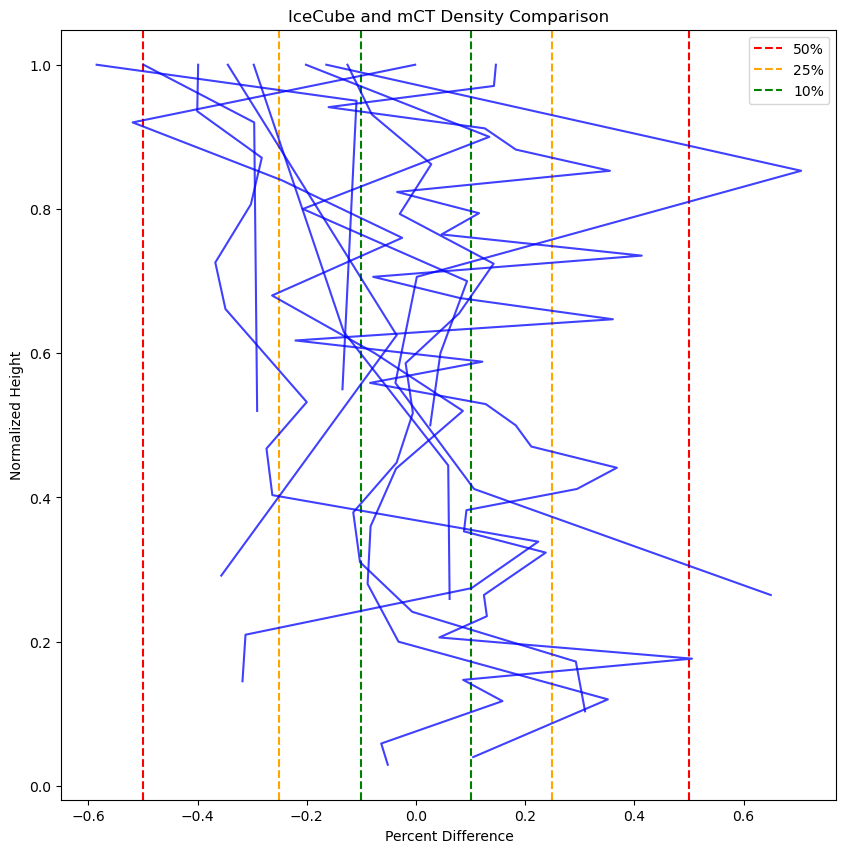

In [9]:
percent_diff_den = {}
#compute percentage difference between IceCube SSA to average of 2.5cm of mCT measurements (should be an average of 6 values with my interpolation)
for name,df in den.items():
    for name2,df2 in mCT_interpolated.items():
        var2 = name.split('_')
        var1 = name2.split('_')
        if var2[1].startswith(var1[0]):
            percent = []
            error = []
            height = []
            for i in range(0,len(df)):
                x = float(df['#Top(cm)'][i])
                idx2 = getIndexes(round(df2*2)/2,x)
                if len(idx2)>0:
                    idx = idx2 
                    if idx[0]>9:
                        den_av = (df2['Percent object volume'][idx[0]]+df2['Percent object volume'][idx[0]-1]+df2['Percent object volume'][idx[0]-2]+df2['Percent object volume'][idx[0]-3]+df2['Percent object volume'][idx[0]-4]+df2['Percent object volume'][idx[0]-5]+df2['Percent object volume'][idx[0]-6]+df2['Percent object volume'][idx[0]-7]+df2['Percent object volume'][idx[0]-8]+df2['Percent object volume'][idx[0]-9])
                        temp = (df['Avg_density(kg/m^3)'][i]-den_av)/(den_av) #calculate bias with mCT as true
                        temp2 = df['#Top(cm)'][i]
                        temp4 = (abs(df['Avg_density(kg/m^3)'][i]-den_av))
                        percent.append(temp)
                        height.append(temp2)
                        error.append(temp4)
                    else:
                        continue
                d = {'Height':height,'Percent Difference':percent,'Error':error}
                percent_diff_den[name] = pd.DataFrame(d)
den_bias = []
for name,df in percent_diff_den.items():
    den_bias.append(df)
df_den = pd.concat(den_bias,axis=0,ignore_index=True)
display(df_den)

#3. Figure out the mean and std. of the percentage difference
total_n_den = [len(df_den)]

p_den = df_den['Percent Difference']
e_den = df_den['Error']
mean_bias = [np.mean(p_den)]
max_bias = [np.max(p_den)]
std_bias = [np.std(p_den)]

mean_error_den = [np.mean(e_den)]
max_error_den = [np.max(e_den)]
std_error_den = [np.std(e_den)]

den_d = {'Mean Bias':mean_bias,'Max Bias':max_bias,'Std Bias':std_bias,'Mean Absolute Error':mean_error_den,'Max Absolute Error':max_error_den,'Absolute Error Sts':std_error_den,'Sample Size':total_n_den}
den_stats = pd.DataFrame(den_d)
display(den_stats)


plt.figure(figsize=(10,10))
plt.axvline(0.5,color = 'r',ls='--',label='50%')
plt.axvline(0.25,color = 'orange',ls='--',label='25%')
plt.axvline(0.1,color = 'g',ls='--',label='10%')
plt.axvline(-0.5,color = 'r',ls='--')
plt.axvline(-0.25,color = 'orange',ls='--')
plt.axvline(-0.1,color = 'g',ls='--')
plt.legend()
plt.xlabel('Percent Difference')
plt.ylabel('Normalized Height')
plt.title('IceCube and mCT Density Comparison')
percent_diff_den_norm = percent_diff_den.copy()
for name,df in percent_diff_den_norm.items():
    norm = np.max(df['Height'])
    temp = (df['Height']) / norm
    df['Height'] = temp
    x = df['Percent Difference']
    y = df['Height']
    ysmoothed = gaussian_filter1d(y, sigma=2)
    xsmoothed = gaussian_filter1d(x, sigma=3)
    plt.plot(x,y,'b',alpha=0.75)
    #plt.title(name.split('_')[1])

In [10]:
bias = []
for name,df in percent_diff.items():
    bias.append(df)
df_p = pd.concat(bias,axis=0,ignore_index=True)

z2 = stats.zscore(df_p['SSA_IC'])
df_p['zscore'] = z2

display(df_p)
df_p.to_csv('ic_stats_raw.csv', index=False, encoding='utf-8')

#3. Figure out the mean and std. of the percentage difference
colors = {'PP':'r','DF':'r','RG':'g','FC':'b','FCxr<1':'r','FCxr':'y','MFcr':'m','MF':'m','DH':'c','IF':'k'}
color_map = df_p['GrainType'].map(colors)  

,Location,Height,Percent Difference,Error,GrainType,SSA_mCT,SSA_IC,Method,Air Temp,Snow Temp,Moisture,zscore
0,baconrind1,1.000000,14.616693,110.818369,PP,7.581631,118.4,compacted,-4.7,-2.4,D,9.561635
1,baconrind1,1.000000,11.226921,85.118369,PP,7.581631,92.7,mixed,-4.7,NaN,D,7.140934
2,baconrind1,0.944444,0.510430,2.906257,MF,5.693743,8.6,normal,-4.7,NaN,D,-0.780504
3,baconrind1,0.888889,-0.181283,1.262111,MF,6.962111,5.7,normal,-4.7,-2.0,D,-1.053657
4,baconrind1,0.833333,-0.253528,1.800064,MF,7.100064,5.3,normal,-4.7,NaN,D,-1.091334
...,...,...,...,...,...,...,...,...,...,...,...,...
356,togwotee1,0.250000,-0.092888,1.023993,FCxr,11.023993,10.0,normal,-9.0,NaN,D,-0.648637
357,togwotee1,0.214286,0.036835,0.376577,FC,10.223423,10.6,normal,-9.0,-1.5,D,-0.592123
358,togwotee1,0.178571,-0.189608,2.597079,FC,13.697079,11.1,normal,-9.0,NaN,D,-0.545028
359,togwotee1,0.142857,-0.480122,7.665269,MFcr,15.965269,8.3,stacked,-9.0,-1.8,D,-0.808762


Text(0, 0.5, 'Micro-CT SSA')

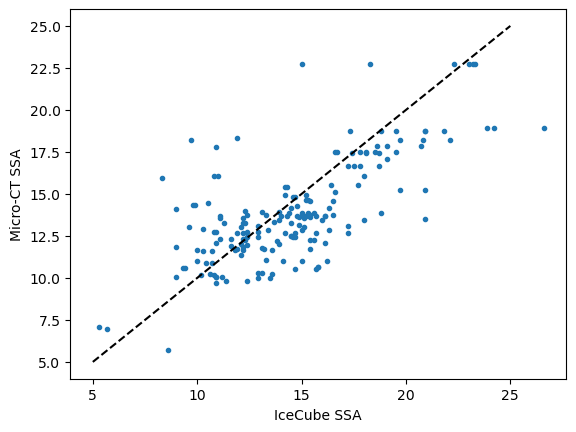

In [11]:
p = df_p['Percent Difference']
e = df_p['Error']
g = df_p['GrainType']
l = df_p['Location']
s1 = df_p['SSA_mCT']
s2 = df_p['SSA_IC']
m = df_p['Method']
w = df_p['Moisture']
h = df_p['Height']

plt.plot(s2[g!='PP'][g!='DF'][g!='DH'][g!='FCxr<1'][w=='D'],s1[g!='PP'][g!='DF'][g!='DH'][g!='FCxr<1'][w=='D'],'.')
plt.plot([5,25],[5,25],'k--')
plt.xlabel('IceCube SSA')
plt.ylabel('Micro-CT SSA')
#plt.title('Snow SSA Measured Using IceCube and Micro-CT')

In [12]:
df_p.drop(df_p[df_p['GrainType']=='PP'].index,inplace=True)
df_p.drop(df_p[df_p['GrainType']=='DF'].index,inplace=True)
df_p.drop(df_p[df_p['GrainType']=='DH'].index,inplace=True)
df_p.drop(df_p[df_p['GrainType']=='FCxr<1'].index,inplace=True)
df_p.drop(df_p[df_p['GrainType']=='MF'].index,inplace=True)
#df_p.drop(df_p[df_p['GrainType']=='MFcr'].index,inplace=True)
df_p.drop(df_p[df_p['Moisture']!='D'].index,inplace=True)

display(df_p)
#df_p.to_csv('ic_stats_filt.csv', index=False, encoding='utf-8')

#redefine subsets
p = df_p['Percent Difference']
e = df_p['Error']
g = df_p['GrainType']
l = df_p['Location']
s1 = df_p['SSA_mCT']
s2 = df_p['SSA_IC']
m = df_p['Method']
w = df_p['Moisture']
h = df_p['Height']
z = df_p['zscore']

,Location,Height,Percent Difference,Error,GrainType,SSA_mCT,SSA_IC,Method,Air Temp,Snow Temp,Moisture,zscore
20,berthoud1,0.984000,0.295218,4.490200,MFcr,15.209800,19.7,stacked,-9.8,NaN,D,0.265012
21,berthoud1,0.984000,0.374114,5.690200,MFcr,15.209800,20.9,stacked,-9.8,NaN,D,0.378041
46,berthoud1,0.840000,0.141607,2.580075,FCxr,18.219925,20.8,normal,-9.8,NaN,D,0.368622
47,berthoud1,0.840000,0.081234,1.480075,FCxr,18.219925,19.7,normal,-9.8,NaN,D,0.265012
48,berthoud1,0.840000,0.212958,3.880075,FCxr,18.219925,22.1,normal,-9.8,NaN,D,0.491070
...,...,...,...,...,...,...,...,...,...,...,...,...
356,togwotee1,0.250000,-0.092888,1.023993,FCxr,11.023993,10.0,normal,-9.0,NaN,D,-0.648637
357,togwotee1,0.214286,0.036835,0.376577,FC,10.223423,10.6,normal,-9.0,-1.5,D,-0.592123
358,togwotee1,0.178571,-0.189608,2.597079,FC,13.697079,11.1,normal,-9.0,NaN,D,-0.545028
359,togwotee1,0.142857,-0.480122,7.665269,MFcr,15.965269,8.3,stacked,-9.0,-1.8,D,-0.808762


                            OLS Regression Results                            
Dep. Variable:                SSA_mCT   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     157.1
Date:                Wed, 24 May 2023   Prob (F-statistic):           3.31e-26
Time:                        16:43:50   Log-Likelihood:                -388.66
No. Observations:                 179   AIC:                             781.3
Df Residuals:                     177   BIC:                             787.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6744      0.684      8.294      0.0

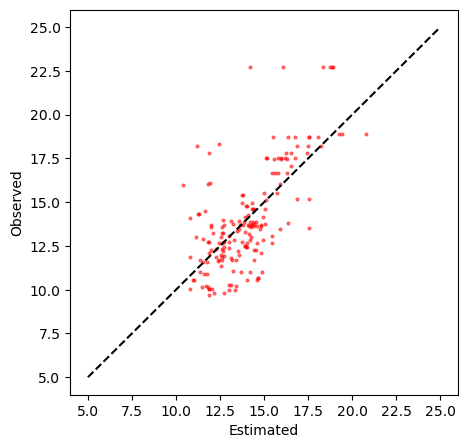

In [13]:
y = s1.copy()
x = sm.add_constant(s2.copy())
x

model1 = sm.OLS(y,x).fit()
yhat = model1.predict(x)

plt.figure(figsize=(5,5))
plt.plot(yhat,y,'o',markersize=2,alpha=0.5,c='r')
plt.plot([5,25],[5,25],'--k')
plt.xlabel('Estimated')
plt.ylabel('Observed')

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                SSA_mCT   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     7.838
Date:                Wed, 24 May 2023   Prob (F-statistic):            0.00770
Time:                        16:43:53   Log-Likelihood:                -77.245
No. Observations:                  44   AIC:                             158.5
Df Residuals:                      42   BIC:                             162.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1970      1.735      4.726      0.0

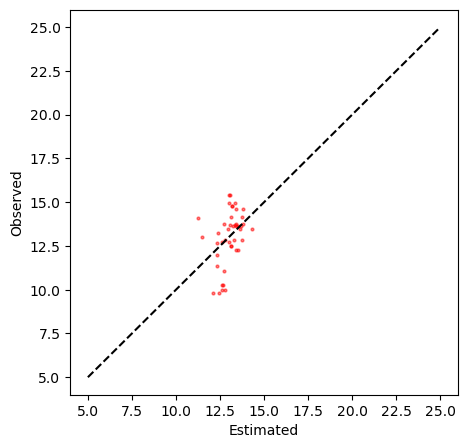

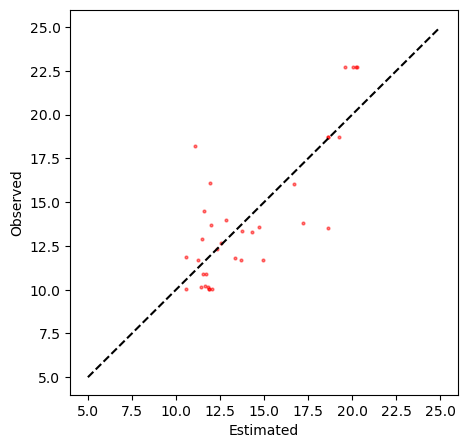

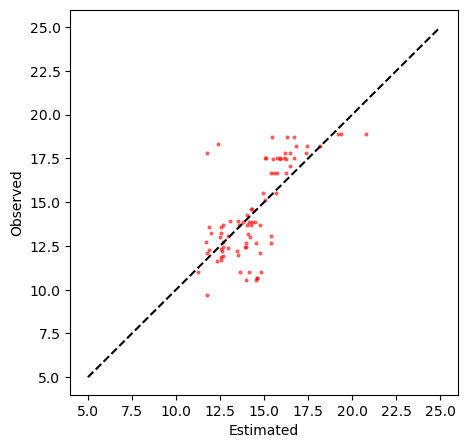

In [14]:
main_grains = ['RG','FC','FCxr']
for grain in main_grains:
    y = s1[g==grain].copy()
    x = sm.add_constant(s2[g==grain].copy())
    x

    model1 = sm.OLS(y,x).fit()
    yhat = model1.predict(x)

    plt.figure(figsize=(5,5))
    plt.plot(yhat,y,'o',markersize=2,alpha=0.5,c='r')
    plt.plot([5,25],[5,25],'--k')
    plt.xlabel('Estimated')
    plt.ylabel('Observed')

    print(model1.summary())

In [15]:
#evaluate outliers
outliers1 = df_p[z>.7]
outliers2 = df_p[z<-.7]

display(outliers1,outliers2)

,Location,Height,Percent Difference,Error,GrainType,SSA_mCT,SSA_IC,Method,Air Temp,Snow Temp,Moisture,zscore
217,clebp2,0.4,0.407367,7.699454,FCxr,18.900546,26.6,shaved,-1.0,-5.0,D,0.914928


,Location,Height,Percent Difference,Error,GrainType,SSA_mCT,SSA_IC,Method,Air Temp,Snow Temp,Moisture,zscore
115,berthoud1,0.288000,-0.104452,1.049713,FC,10.049713,9.0,normal,-9.8,-1.7,D,-0.742828
121,berthoud1,0.240000,-0.111191,1.175953,MFcr,10.575953,9.4,stacked,-9.8,NaN,D,-0.705152
122,berthoud1,0.240000,-0.120647,1.275953,MFcr,10.575953,9.3,stacked,-9.8,NaN,D,-0.714571
259,fraser3,0.156250,-0.240962,2.857112,FC,11.857112,9.0,shaved,-12.0,-1.3,D,-0.742828
329,pinecreek1,0.324324,-0.361740,5.100845,RG,14.100845,9.0,shaved,-9.9,NaN,D,-0.742828
359,togwotee1,0.142857,-0.480122,7.665269,MFcr,15.965269,8.3,stacked,-9.0,-1.8,D,-0.808762


## IceCube SSA Statistics
###### The following sections calculate IceCube statistics relating to SSA bias and error. 

C:\Users\meyer.1597.RF\AppData\Local\Temp\1\ipykernel_20684\2838745344.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(x*0.1) for x in y_vals])


,Grain Type,Max Bias,Mean Bias,Median Bias,Bias Standard Deviation,Standard Deviation 67%,Max Absolute Error,Median Absolute Error,Absolute Error Standard Deviation,RMSE,Sample Size,P-value All
0,RG,0.361740,0.097485,0.119615,0.146108,0.176784,5.100845,1.711849,1.223865,2.156322,44,0.061227
1,FC,0.544113,0.012290,0.025611,0.190108,0.138578,8.487216,1.298557,1.955186,2.787688,35,0.122035
2,FCxr,0.488713,0.084680,0.055206,0.166779,0.141442,7.699454,1.316616,1.732532,2.567921,83,0.065903
3,MFcr,0.480122,-0.077390,-0.115919,0.243339,0.306874,7.718164,3.132998,2.634605,4.345481,12,0.076536
4,IF,0.331502,-0.096242,-0.111452,0.235300,0.313414,4.520125,3.385971,1.535571,3.283245,5,0.250288
5,Overall,0.544113,0.057755,0.047235,0.183693,0.161215,8.487216,1.480075,1.794634,2.699470,179,NaN


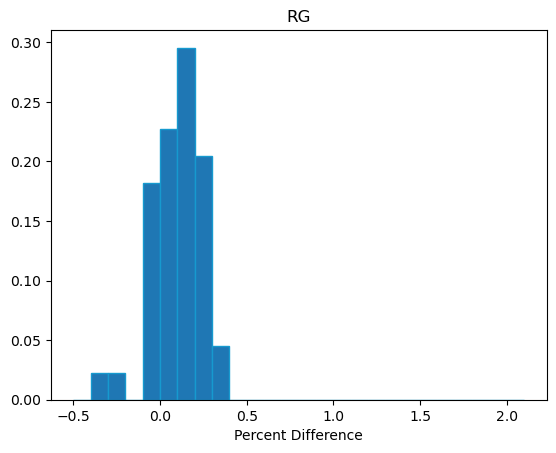

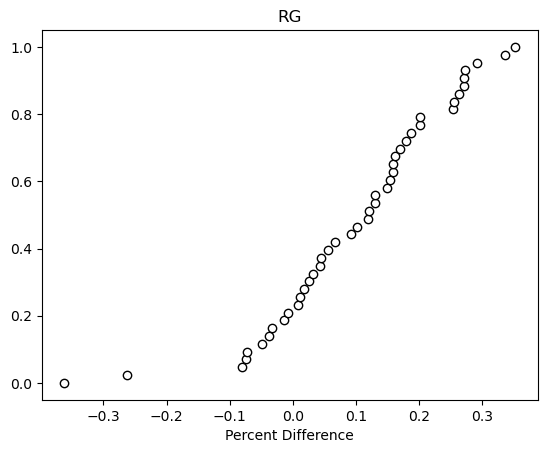

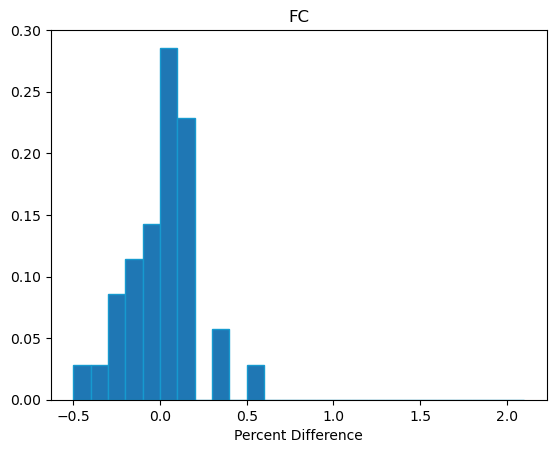

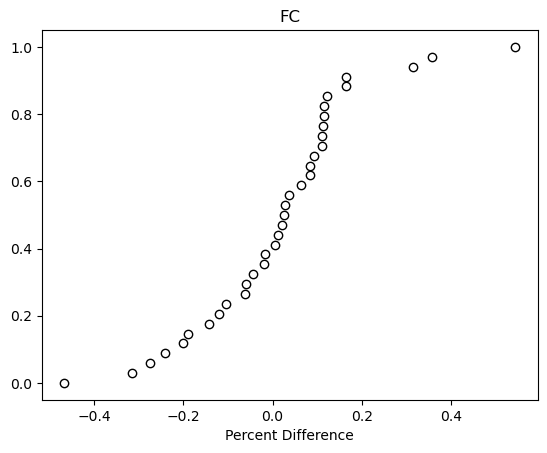

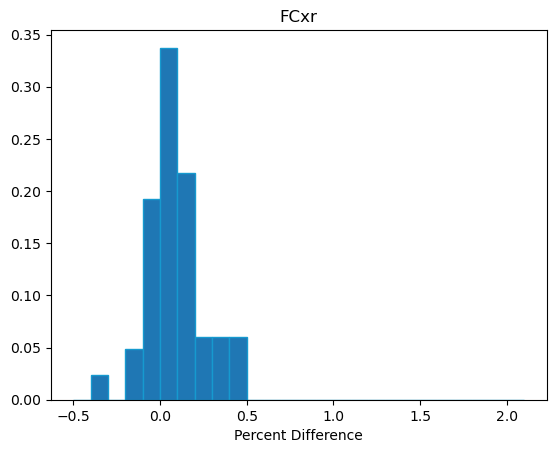

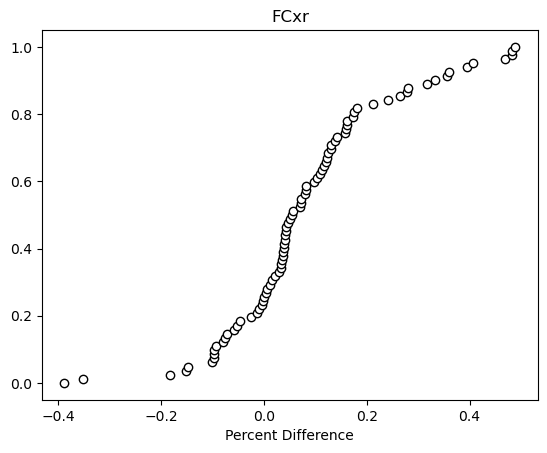

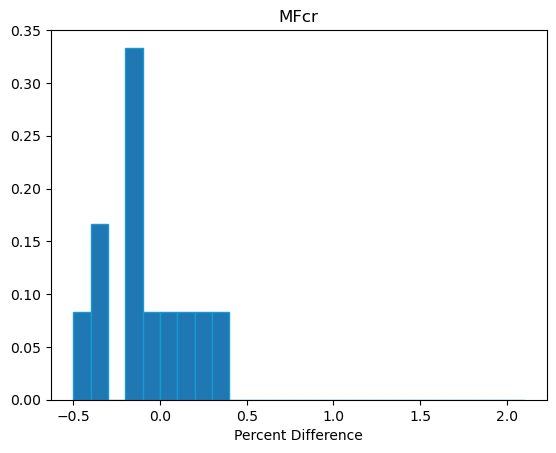

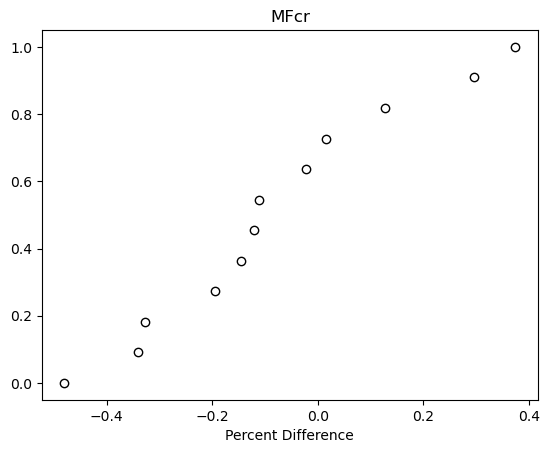

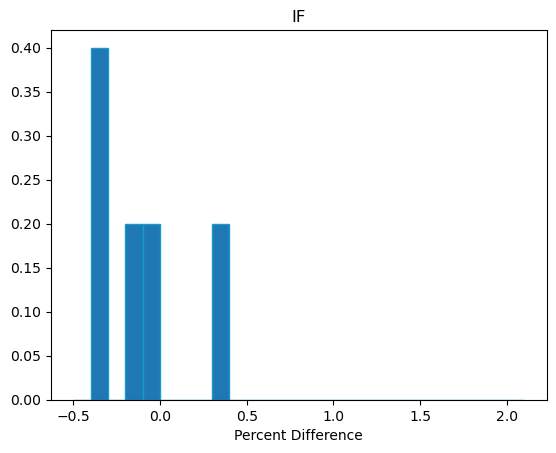

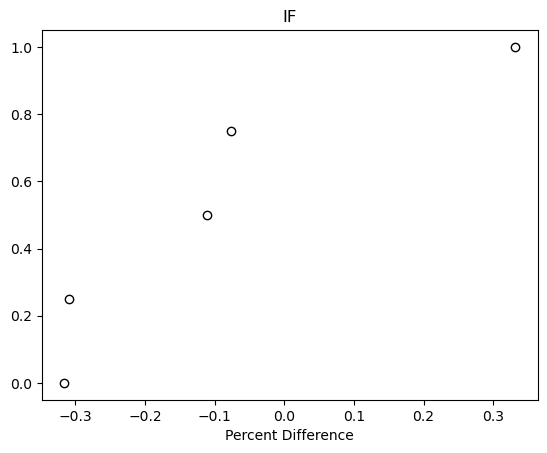

In [16]:
p = df_p['Percent Difference']
e = df_p['Error']
g = df_p['GrainType']
l = df_p['Location']
s1 = df_p['SSA_mCT']
s2 = df_p['SSA_IC']
m = df_p['Method']
w = df_p['Moisture']
h = df_p['Height']

grain_types = ['RG','FC','FCxr','MFcr','IF']

total_mean = np.mean(p)
total_std = np.std(p)
total_max = np.max(p)
total_n = len(df_p)

CI = np.quantile(abs(p),np.array([0.67]))
total_std2 = CI[0]
total_median = np.quantile(p,np.array([0.5]))[0]

error_median = np.quantile(e,np.array([0.5]))[0]
error_std = np.std(e)
error_max = np.max(e)

total_rmse = np.sqrt((sum((s2-s1)**2))/total_n)

maxs = []
means = []
medians = []
stds = []
std2s = []
ns = []
max_error = []
median_error = []
std_error = []
rmses = []
p_valueALL = []

for grain in grain_types:
    fig,ax = plt.subplots()
    ax.set_xlabel('Percent Difference')
    ax.set_title(str(grain))
    ax.hist(p[g==grain][w=='D'], bins=np.arange(-0.5,2.2,0.1), density=True, edgecolor='#169acf', linewidth=1)
    y_vals = ax.get_yticks()
    ax.set_yticklabels(['{:.2f}'.format(x*0.1) for x in y_vals])
    
    plt.figure()
    plt.title(str(grain))
    plt.xlabel('Percent Difference')
    plt.scatter(np.sort(p[g==grain][w=='D']), np.linspace(0, 1, len(p[g==grain][w=='D']), endpoint=True), edgecolors=(0,0,0), color='white')
    
    group1 = df_p['Percent Difference'][g==grain]
    group2 = df_p['Percent Difference'][g!='PP'][g!='DF'][g!=grain]
    stat1, p1 = ttest_ind(group1, group2, equal_var=False)
    
    mean = np.mean(p[g==grain][w=='D'])
    median = np.quantile(p[g==grain][w=='D'],np.array([0.5]))[0]
    maxss = np.max(abs(p[g==grain][w=='D']))
    std = np.std(p[g==grain][w=='D'])
    CI = np.quantile(abs(p[g==grain][w=='D']),np.array([0.67]))
    std2 = CI[0]
    medianerror = np.quantile(e[g==grain][w=='D'],np.array([0.5]))[0]
    maxerror = np.max(e[g==grain][w=='D'])
    stderror = np.std(e[g==grain][w=='D'])
    n = len(p[g==grain][w=='D'])
    rmse = np.sqrt((sum((s2[g==grain][w=='D']-s1[g==grain][w=='D'])**2))/n)
    maxs.append(maxss)
    means.append(mean)
    stds.append(std)
    max_error.append(maxerror)
    median_error.append(medianerror)
    std_error.append(stderror)
    medians.append(median)
    std2s.append(std2)
    ns.append(n)
    rmses.append(rmse)
    p_valueALL.append(p1)

d_grains = {'Grain Type':grain_types,'Max Bias':maxs,'Mean Bias':means,'Median Bias':medians,'Bias Standard Deviation':stds,
            'Standard Deviation 67%':std2s,'Max Absolute Error':max_error,'Median Absolute Error':median_error,
            'Absolute Error Standard Deviation':std_error,'RMSE':rmses,'Sample Size':ns,'P-value All':p_valueALL}

df_grains = pd.DataFrame(d_grains)
df_grains.loc[len(df_grains.index)] = ['Overall', total_max, total_mean, total_median, total_std, total_std2, error_max, error_median, error_std, 
                                       total_rmse, total_n,np.nan]

df_grains.to_csv('Ice Cube Stats.csv', index=False, encoding='utf-8')
display(df_grains)

In [17]:
print(np.median(p[g!='PP'][g!='DF'][g!='FCxr<1'][w=='D']))

0.04723480553107563


0.44692737430167595 0.776536312849162 0.8491620111731844 0.994413407821229 179


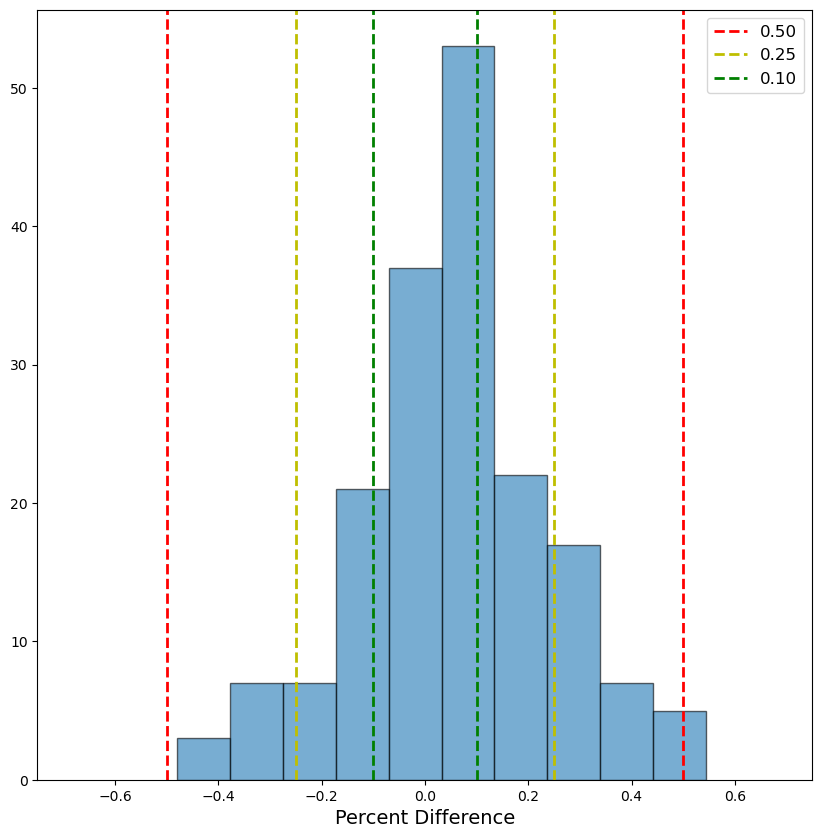

In [18]:
plt.figure(figsize=(10,10))
plt.xlim(-0.75,0.75)
plt.axvline(0.5,color = 'r',ls='--',lw=2,label='0.50')
plt.axvline(0.25,color = 'y',ls='--',lw=2,label='0.25')
plt.axvline(0.1,color = 'g',ls='--',lw=2,label='0.10')
plt.axvline(-0.5,color = 'r',lw=2,ls='--')
plt.axvline(-0.25,color = 'y',lw=2,ls='--')
plt.axvline(-0.1,color = 'g',lw=2,ls='--')
plt.legend(fontsize=12)
plt.xlabel('Percent Difference', fontsize=14)
#plt.title('IceCube and mCT SSA Comparison')
x = p
plt.hist(x, edgecolor='black', linewidth=1, alpha = 0.6)

total = len(p[w=='D'][g!='PP'][g!='DF'][g!='FCxr<1'][g!='DH'])
ten = (len(p[w=='D'][g!='PP'][g!='DF'][g!='FCxr<1'][g!='DH'][abs(p)<0.1]))/total
thirty = (len(p[w=='D'][g!='PP'][g!='DF'][g!='FCxr<1'][g!='DH'][abs(p)<0.3]))/total
quarter = (len(p[w=='D'][g!='PP'][g!='DF'][g!='FCxr<1'][g!='DH'][abs(p)<0.25]))/total
fifty = (len(p[w=='D'][g!='PP'][g!='DF'][g!='FCxr<1'][g!='DH'][abs(p)<0.5]))/total
total = len(p[w=='D'][g!='PP'][g!='DF'][g!='FCxr<1'][g!='DH'])
print(ten, quarter, thirty, fifty, total)
                                                               

## What are controls on the IceCube's SSA error?
###### The following sections test whether the bias and error of the IceCube correlate significantly with any variables (grain type, temperature, grain size, etc.)

<AxesSubplot:title={'center':'Bias'}, xlabel='GrainType', ylabel='Percent Difference'>

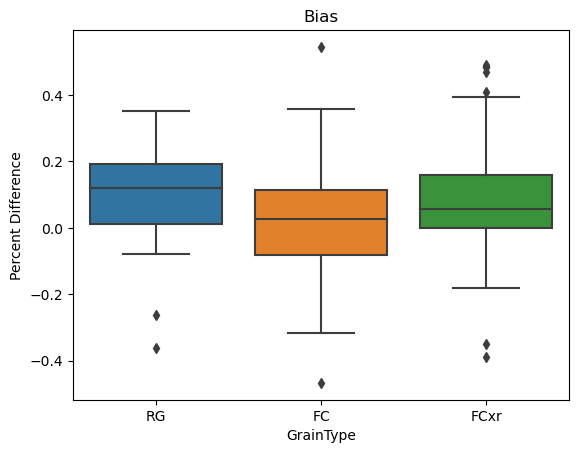

In [19]:
df_box = df_p
import seaborn as sns
plt.figure()
plt.title('Bias')
sns.boxplot(df_box,x='GrainType',y='Percent Difference',order=['RG','FC','FCxr'],orient='v')

In [20]:
df = pd.read_csv('./ic_stats_raw.csv')
df = df[df['Moisture']=='D']
df

,Location,Height,Percent Difference,Error,GrainType,SSA_mCT,SSA_IC,Method,Air Temp,Snow Temp,Moisture,zscore
0,baconrind1,1.000000,14.616693,110.818369,PP,7.581631,118.4,compacted,-4.7,-2.4,D,9.561635
1,baconrind1,1.000000,11.226921,85.118369,PP,7.581631,92.7,mixed,-4.7,NaN,D,7.140934
2,baconrind1,0.944444,0.510430,2.906257,MF,5.693743,8.6,normal,-4.7,NaN,D,-0.780504
3,baconrind1,0.888889,-0.181283,1.262111,MF,6.962111,5.7,normal,-4.7,-2.0,D,-1.053657
4,baconrind1,0.833333,-0.253528,1.800064,MF,7.100064,5.3,normal,-4.7,NaN,D,-1.091334
...,...,...,...,...,...,...,...,...,...,...,...,...
356,togwotee1,0.250000,-0.092888,1.023993,FCxr,11.023993,10.0,normal,-9.0,NaN,D,-0.648637
357,togwotee1,0.214286,0.036835,0.376577,FC,10.223423,10.6,normal,-9.0,-1.5,D,-0.592123
358,togwotee1,0.178571,-0.189608,2.597079,FC,13.697079,11.1,normal,-9.0,NaN,D,-0.545028
359,togwotee1,0.142857,-0.480122,7.665269,MFcr,15.965269,8.3,stacked,-9.0,-1.8,D,-0.808762


In [21]:
import math
import numpy as np
from scipy.stats import shapiro 
from scipy.stats import lognorm

grain_types = ['PP','DF','RG','FC','FCxr','FCxr<1','MFcr','MF','DH','IF']
norm = []
samp_size = []
for grain in grain_types:
    data = df['Percent Difference'][df['GrainType']==grain]
    result = shapiro(data)
    samp_size.append(len(data))
    print(grain,result[1])
    if result[1] > 0.05:
        norm.append('Yes')
    else:
        norm.append('No')

grain_comp = {'Grain Type':grain_types,'Normal?':norm,'Sample Size':samp_size}
grain_comp = pd.DataFrame(grain_comp)
display(grain_comp)

PP 0.0077439649030566216
DF 0.15202869474887848
RG 0.08393724262714386
FC 0.30369776487350464
FCxr 0.0042303139343857765
FCxr<1 0.00015860550047364086
MFcr 0.9101715683937073
MF 0.16377173364162445
DH 0.2847471535205841
IF 0.20546171069145203


,Grain Type,Normal?,Sample Size
0,PP,No,7
1,DF,Yes,21
2,RG,Yes,44
3,FC,Yes,35
4,FCxr,No,83
5,FCxr<1,No,24
6,MFcr,Yes,12
7,MF,Yes,3
8,DH,Yes,18
9,IF,Yes,5


In [22]:
grains = []
for i in range(len(grain_comp)):
    if grain_comp['Normal?'][i] =='Yes' and grain_comp['Sample Size'][i] >15:
        grains.append(grain_comp['Grain Type'][i])

p_values = []
for i in range(0,len(grains)):
    for j in range(0,len(grains)):
        group1 = df['Percent Difference'][df['GrainType']==grains[i]]
        group2 = df['Percent Difference'][df['GrainType']==grains[j]]
        stat, p = ttest_ind(group1, group2, equal_var=False)
        p_values.append(p)
        
p_values = np.array(p_values)
p_values = np.reshape(p_values,[4,4])
p_values = pd.DataFrame(p_values,columns=grains,index=grains)
display(p_values)

,DF,RG,FC,DH
DF,1.000000e+00,3.668947e-03,4.609931e-04,2.250916e-09
RG,3.668947e-03,1.000000e+00,3.483322e-02,1.688770e-19
FC,4.609931e-04,3.483322e-02,1.000000e+00,6.930097e-16
DH,2.250916e-09,1.688770e-19,6.930097e-16,1.000000e+00


In [23]:
similar = []
for i in range(0,len(grains)):
    for j in range(0,len(grains)):
        group1 = df['Percent Difference'][df['GrainType']==grains[i]]
        group2 = df['Percent Difference'][df['GrainType']==grains[j]]
        stat, p = ttest_ind(group1, group2, equal_var=False)
        if p>0.05:
            similar.append('Yes')
        else:
            similar.append('No')

similar = np.array(similar)
similar = np.reshape(similar,[4,4])
similar = pd.DataFrame(similar,columns=grains,index=grains)
display(similar)

,DF,RG,FC,DH
DF,Yes,No,No,No
RG,No,Yes,No,No
FC,No,No,Yes,No
DH,No,No,No,Yes


In [24]:
df_p = df_p.reset_index(drop = True)
display(df_p)

,Location,Height,Percent Difference,Error,GrainType,SSA_mCT,SSA_IC,Method,Air Temp,Snow Temp,Moisture,zscore
0,berthoud1,0.984000,0.295218,4.490200,MFcr,15.209800,19.7,stacked,-9.8,NaN,D,0.265012
1,berthoud1,0.984000,0.374114,5.690200,MFcr,15.209800,20.9,stacked,-9.8,NaN,D,0.378041
2,berthoud1,0.840000,0.141607,2.580075,FCxr,18.219925,20.8,normal,-9.8,NaN,D,0.368622
3,berthoud1,0.840000,0.081234,1.480075,FCxr,18.219925,19.7,normal,-9.8,NaN,D,0.265012
4,berthoud1,0.840000,0.212958,3.880075,FCxr,18.219925,22.1,normal,-9.8,NaN,D,0.491070
...,...,...,...,...,...,...,...,...,...,...,...,...
174,togwotee1,0.250000,-0.092888,1.023993,FCxr,11.023993,10.0,normal,-9.0,NaN,D,-0.648637
175,togwotee1,0.214286,0.036835,0.376577,FC,10.223423,10.6,normal,-9.0,-1.5,D,-0.592123
176,togwotee1,0.178571,-0.189608,2.597079,FC,13.697079,11.1,normal,-9.0,NaN,D,-0.545028
177,togwotee1,0.142857,-0.480122,7.665269,MFcr,15.965269,8.3,stacked,-9.0,-1.8,D,-0.808762


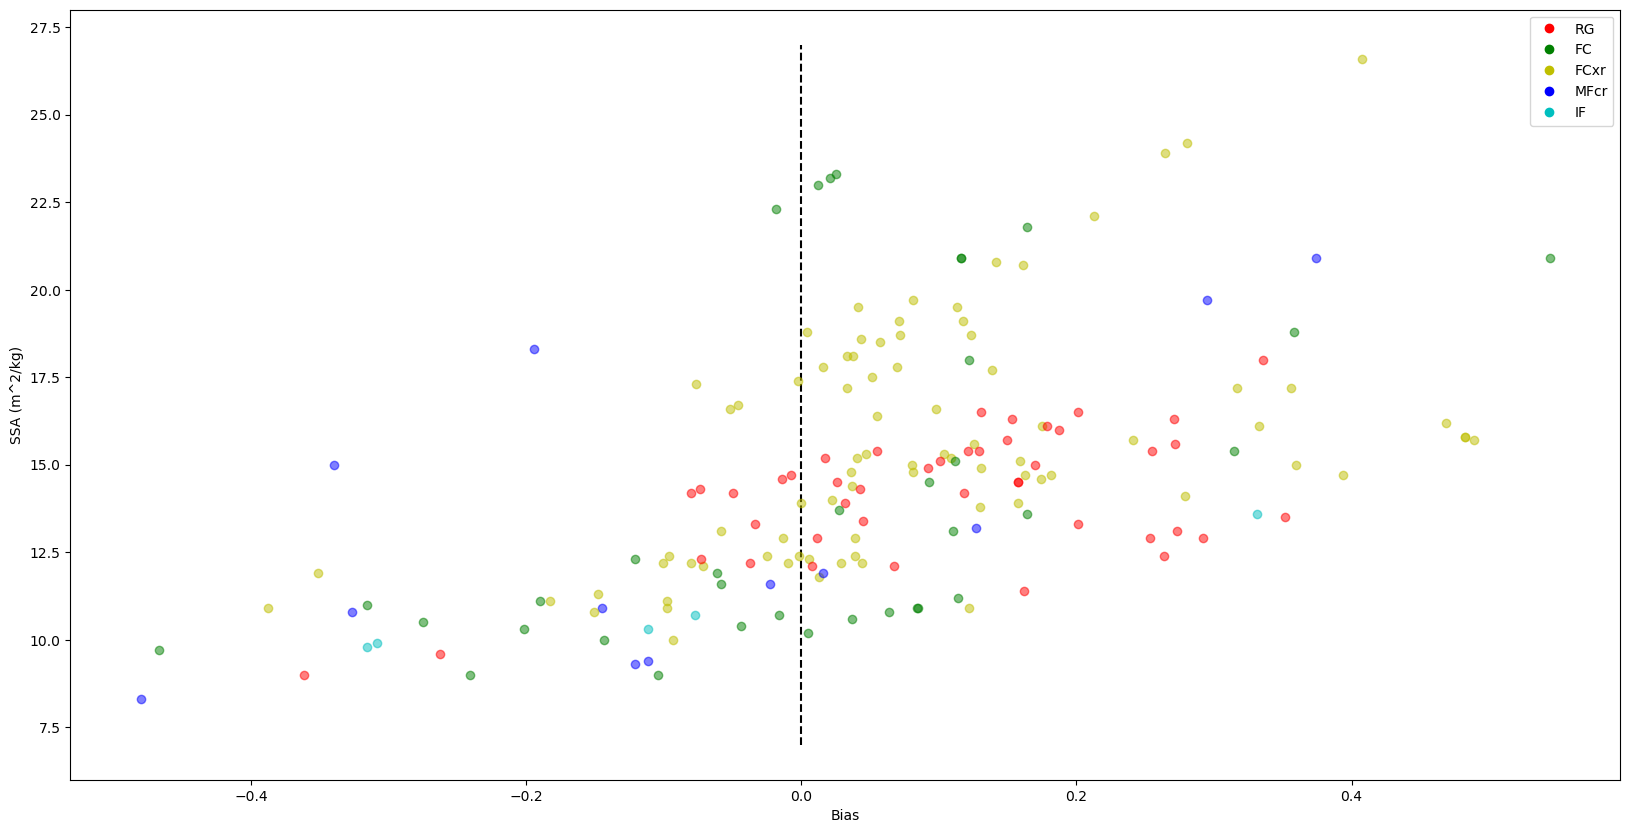

In [25]:
colors = {'RG':'r','FC':'g','FCxr':'y','MFcr':'b','IF':'c'}
color_map = df_p['GrainType'].map(colors)  

plt.figure(figsize=(20,10))
plt.plot([0,0],[7,27],'k--',label='Zero Bias')
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.xlabel('Bias')
plt.ylabel('SSA (m^2/kg)')
for i in range(0,len(df_p)):
    plt.plot(df_p['Percent Difference'][i],df_p['SSA_IC'][i],'o',alpha=0.5,c=color_map[i])
plt.show()

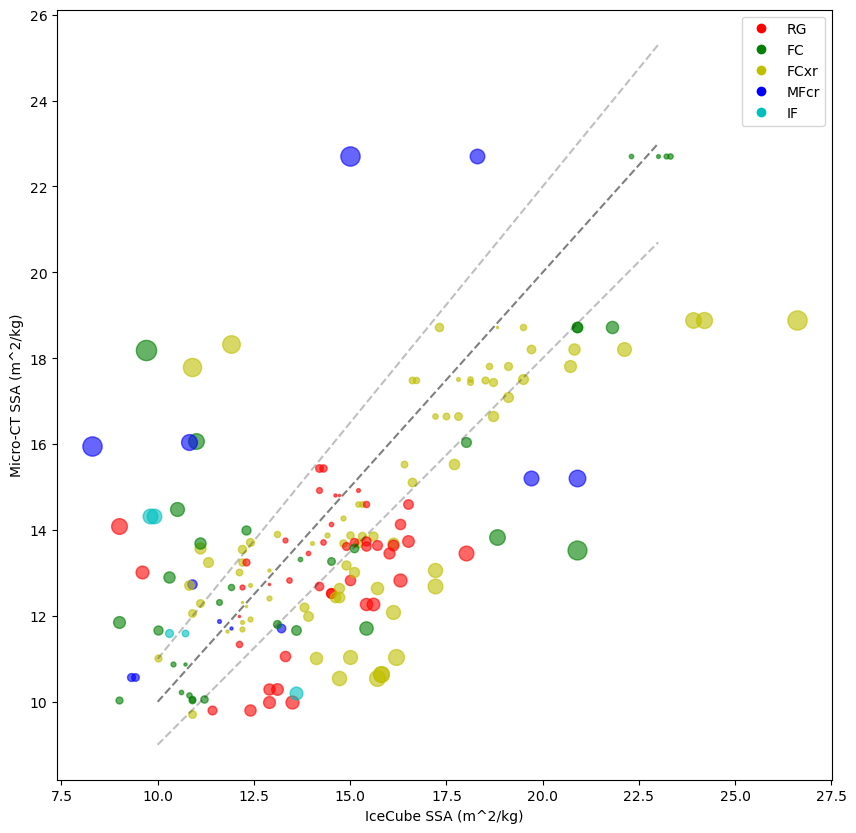

In [26]:
colors = {'RG':'r','FC':'g','FCxr':'y','MFcr':'b','IF':'c'}
color_map = df_p['GrainType'].map(colors)  

s = list(df_p['Error'])
size = []
for i in range(0,len(s)):
    size.append((np.round(s[i],1))*25)

plt.figure(figsize=(10,10))
plt.plot([10,23],[10,23],'k--',alpha=0.5)
plt.plot([(10),(23)],[(10*1.1),(23*1.1)],'k--',alpha=0.25)
plt.plot([10,23],[10*0.9,23*0.9],'k--',alpha=0.25)
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.xlabel('IceCube SSA (m^2/kg)')
plt.ylabel('Micro-CT SSA (m^2/kg)')
for i in range(0,len(df_p)):
    plt.scatter(df_p['SSA_IC'][i],df_p['SSA_mCT'][i],s=size[i],alpha=0.6,c=color_map[i])


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True,font_scale=1.75)
from pykrige.ok import OrdinaryKriging
import statsmodels.api as sm
from scipy.stats import norm, expon, genextreme
from scipy import optimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split

In [28]:
#drop columns not to be used in correlation analysis

df = df_p.copy()
df.drop(columns=['Snow Temp'],inplace=True)
df.drop(columns=['Moisture'],inplace=True)
df.drop(columns=['Method'],inplace=True)
df.drop(columns=['Location'],inplace=True)
df.drop(columns=['Height'],inplace=True)
df.drop(columns=['zscore'],inplace=True)
df.drop(columns=['SSA_IC'],inplace=True)
df.drop(columns=['Percent Difference'],inplace=True)

df.head()

,Error,GrainType,SSA_mCT,Air Temp
0,4.490200,MFcr,15.209800,-9.8
1,5.690200,MFcr,15.209800,-9.8
2,2.580075,FCxr,18.219925,-9.8
3,1.480075,FCxr,18.219925,-9.8
4,3.880075,FCxr,18.219925,-9.8


In [29]:
#assign numeric values to grain types

df['GrainType'].value_counts()

X0 = pd.get_dummies(df, columns = ['GrainType'])
display(X0)

column_headers = list(X0.columns.values)
#print("The Column Header :", column_headers)

X0 = np.array(X0)

,Error,SSA_mCT,Air Temp,GrainType_FC,GrainType_FCxr,GrainType_IF,GrainType_MFcr,GrainType_RG
0,4.490200,15.209800,-9.8,0,0,0,1,0
1,5.690200,15.209800,-9.8,0,0,0,1,0
2,2.580075,18.219925,-9.8,0,1,0,0,0
3,1.480075,18.219925,-9.8,0,1,0,0,0
4,3.880075,18.219925,-9.8,0,1,0,0,0
...,...,...,...,...,...,...,...,...
174,1.023993,11.023993,-9.0,0,1,0,0,0
175,0.376577,10.223423,-9.0,1,0,0,0,0
176,2.597079,13.697079,-9.0,1,0,0,0,0
177,7.665269,15.965269,-9.0,0,0,0,1,0


(179, 8)
8
[[ 1.          0.14201095  0.06338246 -0.00809493 -0.06276207  0.08364007
   0.21496844 -0.07672448]
 [ 0.14201095  1.          0.57326344  0.02770121  0.14355241 -0.09341391
   0.06812797 -0.19559928]
 [ 0.06338246  0.57326344  1.          0.05503578  0.05484919 -0.03649896
   0.04701641 -0.12756181]
 [-0.00809493  0.02770121  0.05503578  1.         -0.45841224 -0.08357245
  -0.13215548 -0.28145711]
 [-0.06276207  0.14355241  0.05484919 -0.45841224  1.         -0.1576209
  -0.24925037 -0.53083907]
 [ 0.08364007 -0.09341391 -0.03649896 -0.08357245 -0.1576209   1.
  -0.04544046 -0.09677648]
 [ 0.21496844  0.06812797  0.04701641 -0.13215548 -0.24925037 -0.04544046
   1.         -0.15303538]
 [-0.07672448 -0.19559928 -0.12756181 -0.28145711 -0.53083907 -0.09677648
  -0.15303538  1.        ]]


[Text(0, 0, 'Error'),
 Text(0, 1, 'SSA_mCT'),
 Text(0, 2, 'Air Temp'),
 Text(0, 3, 'GrainType_FC'),
 Text(0, 4, 'GrainType_FCxr'),
 Text(0, 5, 'GrainType_IF'),
 Text(0, 6, 'GrainType_MFcr'),
 Text(0, 7, 'GrainType_RG')]

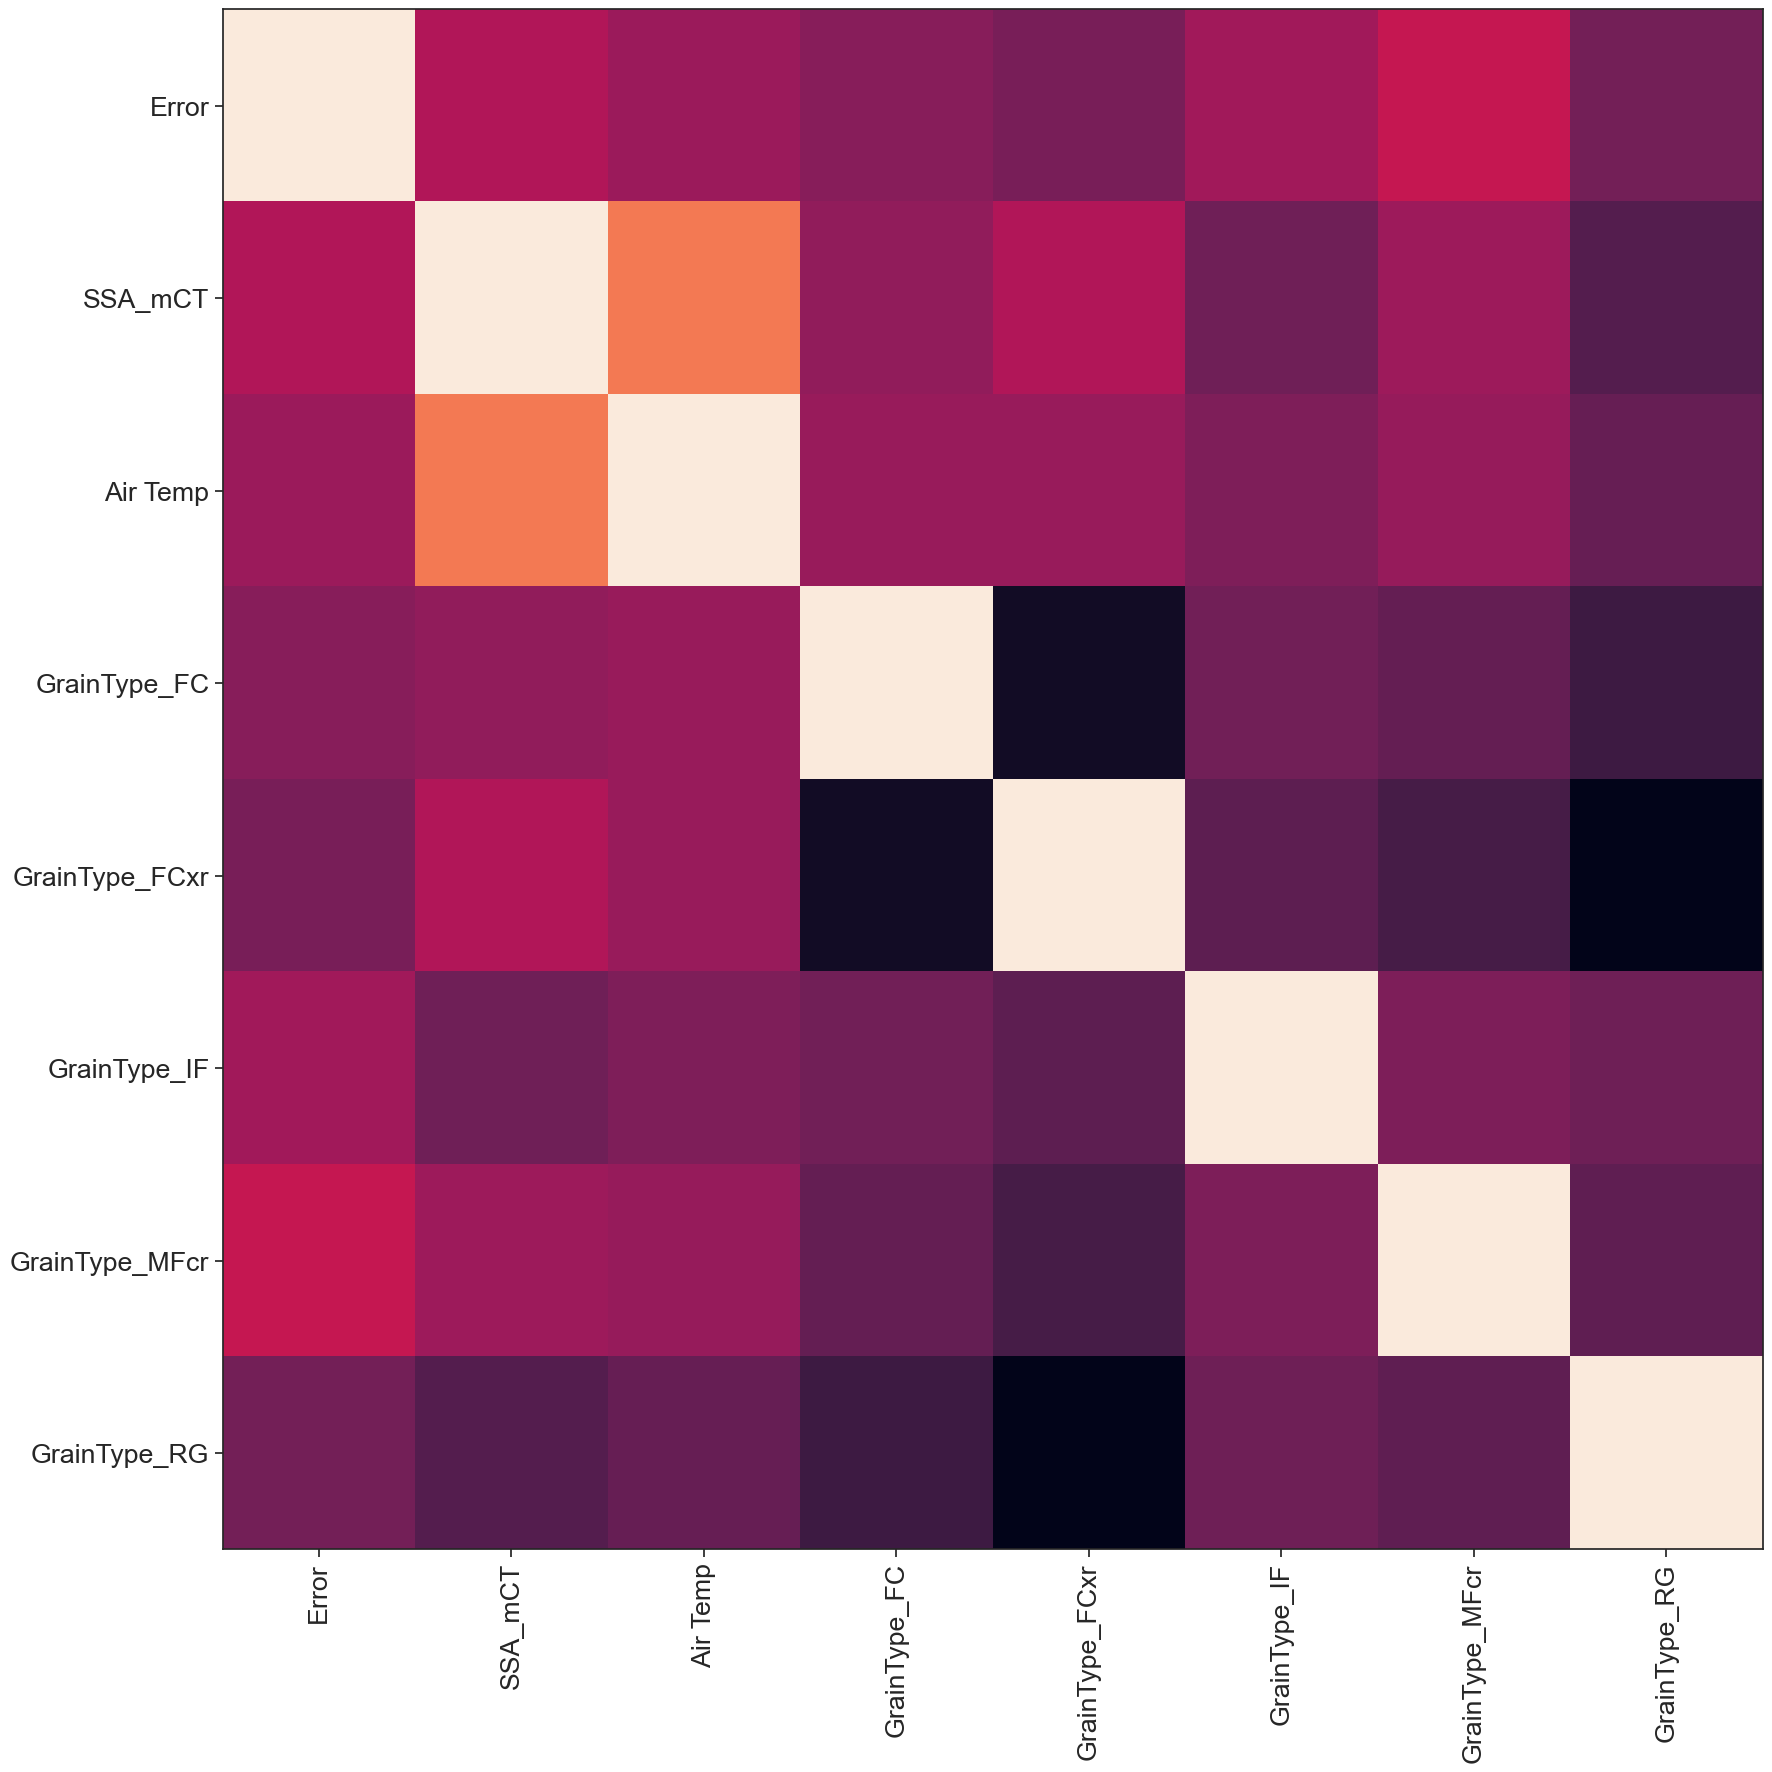

In [30]:
#produce covariance matrix

print(X0.shape)
n = X0.shape[0]
p = X0.shape[1]
print(p)
m0 = np.mean(X0, axis=0)
std0 = np.std(X0, axis=0)
X = (X0 - m0)/std0
#print(np.mean(X,axis=0))
#print(np.std(X,axis=0))

fig,ax = plt.subplots(figsize=(20,20))
S = (np.dot(np.transpose(X),X))/179
print(S)
ax.imshow(S)
ax.set_xticks(np.arange(0,8,1))
ax.set_xticklabels(column_headers,rotation = 90)
ax.set_yticks(np.arange(0,8,1))
ax.set_yticklabels(column_headers,rotation = 0)

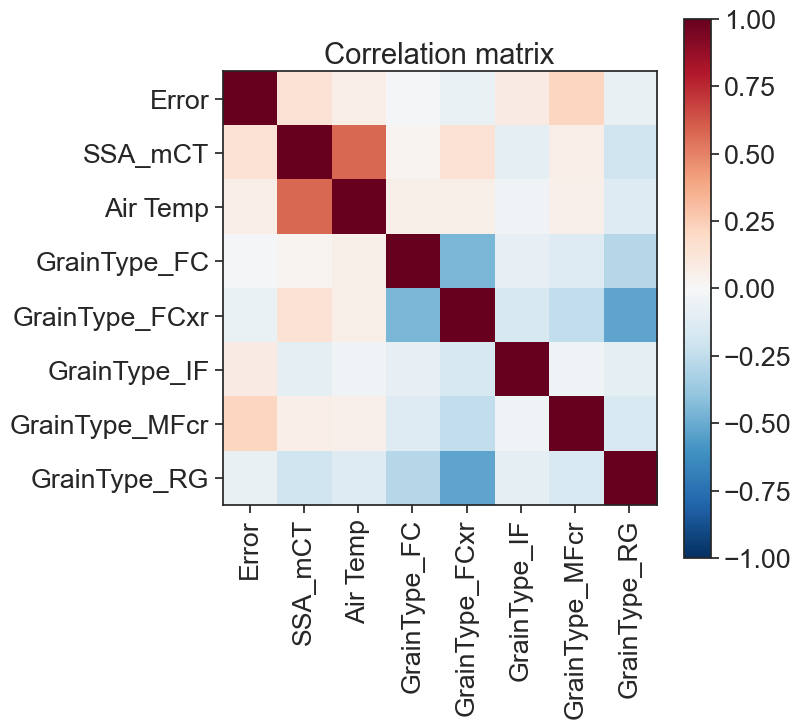

In [31]:
#produce correlation matrix

varlist = np.array(['Error','SSA_mCT','Air Temp','GrainType_FC','GrainType_FCxr','GrainType_IF','GrainType_MFcr','GrainType_RG'])

def plot_corr_matrix(S,varlist):
    plt.figure(figsize=(7,7))
    plt.imshow(S,cmap='RdBu_r',vmin=-1,vmax=1)
    plt.xticks(np.arange(X.shape[1]),varlist,rotation='vertical')
    plt.yticks(np.arange(X.shape[1]),varlist)
    plt.colorbar()
    plt.title('Correlation matrix')

plot_corr_matrix(S,varlist)

# 4. Use the numpy function Use numpy function np.corrcoef() to calculate correlation matrix and visualize
S = np.corrcoef(np.transpose(X))

In [32]:
#find correlation values between each variable and the error

r = np.arange(len(S))
c = np.arange(len(S))
for i in range(len(S)):
    if S[r[0],c[i]]:
        print('r('+varlist[r[0]]+', '+varlist[c[i]]+') = %.2f' %
                 S[r[0],c[i]])

r(Error, Error) = 1.00
r(Error, SSA_mCT) = 0.14
r(Error, Air Temp) = 0.06
r(Error, GrainType_FC) = -0.01
r(Error, GrainType_FCxr) = -0.06
r(Error, GrainType_IF) = 0.08
r(Error, GrainType_MFcr) = 0.21
r(Error, GrainType_RG) = -0.08


In [34]:
#check if error varies significantly with all of the variables in combination

y = X0[:,0].copy()
x = sm.add_constant(X0[:,list([4,5,6,7])].copy())

model1 = sm.OLS(y,x).fit()
yhat = model1.predict(x)

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.606
Date:                Wed, 24 May 2023   Prob (F-statistic):             0.0375
Time:                        16:45:09   Log-Likelihood:                -353.46
No. Observations:                 179   AIC:                             716.9
Df Residuals:                     174   BIC:                             732.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9871      0.299      6.649      0.0